# Dynamic Hedging

In [53]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

Black-Scholes introduced the notion of dynamic delta hedging - by executing delta hedges instantaneously, we ensure that our portfolio is delta neutral, and consequently hedged the exposure of our call position using the underlying stock and the risk-free bond.

The hedged portfolio is $V_t=\phi_tS_t+\psi_tB_t$, where
\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

Let us start by defining these stock and bond holding functions:

In [54]:
def BlackScholesVanillaCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [55]:
def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)


def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)


def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

### Simulate stock price process under the Black-Scholes dynamic, and follow the delta, stock and bond holdings over time until maturity.

In [56]:
# Number of hedging per maturity
steps_21 = 21
steps_84 = 84

# brownian motion path
paths = 50000
# Monthly Maturity
maturity = (1/12)

# For black-scholes model
r = 0.05
S0 = 100.0
K = 100.0
sigma = 0.2

In [57]:
# Define the call option payoff function
def call_option_payoff(ST, K):
    return np.maximum(ST - K, 0)

In [58]:
# Define the objective function to minimize the hedging error
def hedging_error(hedge_ratio, ST, K, ):
    option_payoffs = call_option_payoff(ST, K)
    portfolio_value = option_payoffs - hedge_ratio * ST
    target_value = option_payoffs.mean()
    error = np.abs(portfolio_value.mean() - target_value)
    return error

In [59]:
# For running monte-carlo simulation with the given N values of 21 and 84 respectively.
def hedging_iteration(steps, dt):

  St_simluation = 0

  for i in range(steps):

    S_t = stock_price[:,i]
    S_0 = stock_price[:,i+1]
    delta_t = maturity-T[i]

    Phi = phi(S_t, K, r, sigma, delta_t)

    Bt_Psi = psi_Bt(S_t, K, r, sigma, delta_t)

    St_simluation += (S_0 * Phi + Bt_Psi * np.exp(r*dt) ) - ( S_t * Phi + Bt_Psi )

  return St_simluation

In [70]:
# Print history Summary
def print_histogram_summary(hedging_error, weights, count, call_option, mean_hedge_times, std_hedge_times, percent_hedge_times) -> any:
  plt.hist(hedging_error, weights=weights, bins=np.linspace(-2,2,40))
  plt.xlabel("Hedging Error")
  plt.ylabel("Frequency (%)")
  plt.title(str(count) + ' hedges')
  plt.grid(alpha = 0.3)
  plt.ylim(0,0.25)
  plt.show()

In [61]:
def compute_errors(T, blackscholespath, dt, K, r, sigma, maturity) -> any:
  deltas = []
  stockhedge_errors = []
  bondhedge_errors = []
  hedged_portfolios = []
  stock_holdings = []
  bond_holdings = []

  for t, S_t in zip(T, blackscholespath):

    stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
    bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)

    V_t = stock_pos + bond_pos
    stock_holdings.append(stock_pos)
    bond_holdings.append(bond_pos)
    hedged_portfolios.append(V_t)
    deltas.append(phi(S_t, K, r, sigma, maturity-t))
    if t == 0.0:
        stockhedge_errors.append(0)
        bondhedge_errors.append(0)
    else:
        stockhedge_errors.append(prev_phi*S_t - stock_pos)
        bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

    prev_phi = phi(S_t, K, r, sigma, maturity-t)
    prev_bond_pos = bond_pos

  return deltas,stock_holdings,stock_holdings,hedged_portfolios,stockhedge_errors,bondhedge_errors

In [62]:
def plt_all_info(T, blackscholespath, delta, stock_holdings, bond_holdings, hedged_portfolios, stockhedge_errors, bondhedge_errors) -> any:
  plt.figure(tight_layout=True, figsize=(10, 10))
  plt.subplot(321)
  plt.plot(T, blackscholespath)
  plt.title('Stock price process')
  plt.subplot(322)
  plt.plot(T, delta)
  plt.title('Delta')
  plt.subplot(323)
  plt.plot(T, stock_holdings)
  plt.title('Stock holding')
  plt.subplot(324)
  plt.plot(T, bond_holdings)
  plt.title('Bond holding')
  plt.subplot(325)
  plt.plot(T, hedged_portfolios)
  plt.title('Hedged portfolio')
  plt.subplot(326)
  plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
  plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
  plt.legend()
  plt.title('Hedging error')
  plt.show()

### N = 21 Simulation

In [63]:
T, W_T = simulate_Brownian_Motion(paths, steps_21, maturity)

dt_21 = maturity / steps_21

blackscholespath = S0 * np.exp( ( r-sigma ** 2/2 ) * T + sigma * W_T[0] )

<ipython-input-55-0b2e10c02020>:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
<ipython-input-55-0b2e10c02020>:7: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


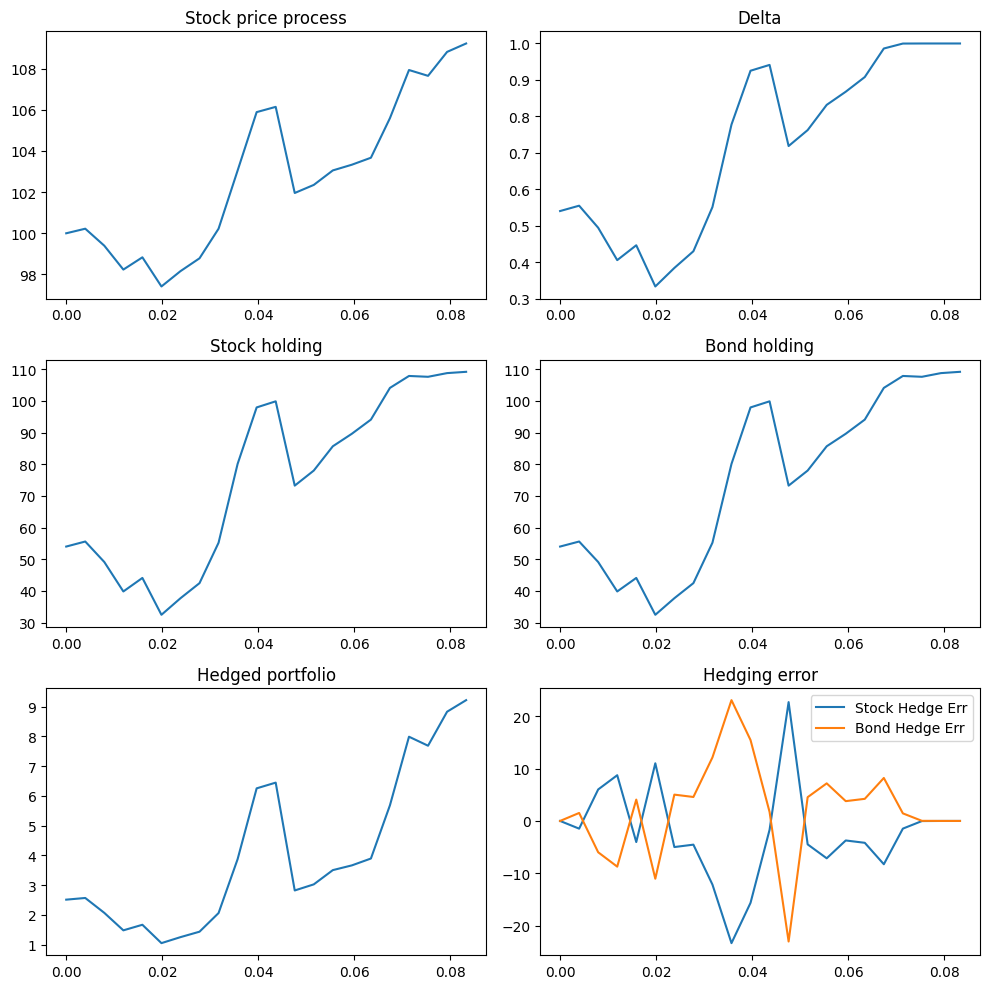

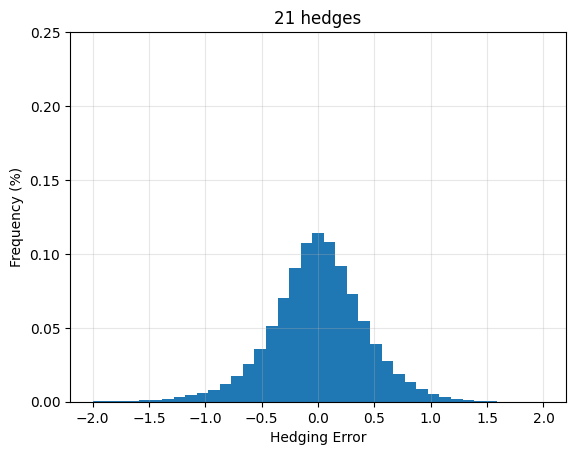

Call option is 2.5120670860398846
Mean is -0.0034109592475005815
Standard Deviation is 0.4255821522285596
Standard Deviation of Hedging Error as a % of option premium 0.1694151221492508


In [64]:
## Plots Result
delta, stock_holdings, bond_holdings, hedged_portfolios, stockhedge_errors, bondhedge_errors = compute_errors(T, blackscholespath, dt_21, K, r, sigma, maturity)

plt_all_info(T, blackscholespath, delta, stock_holdings, bond_holdings, hedged_portfolios, stockhedge_errors, bondhedge_errors)


## Histogram Results
stock_price = S0*np.exp((r-sigma**2/2)*T + sigma*W_T)

iterative_hedging_result = hedging_iteration(steps_21, dt_21)

call_option = BlackScholesVanillaCall(S0, K, r, sigma, maturity)

payoffs = call_option_payoff(stock_price[:,steps_21], K)

hedging_error = iterative_hedging_result + call_option - payoffs

weights=np.ones(len(hedging_error))/len(hedging_error)

mean_of_21_hedge_times = hedging_error.mean()

std_of_21_hedge_times = hedging_error.std()

percent_of_21_hedge_times = std_of_21_hedge_times / call_option

price_check=S0*np.exp(r*T)

print_histogram_summary(hedging_error, weights, 21, call_option, mean_of_21_hedge_times, std_of_21_hedge_times, percent_of_21_hedge_times)

### N = 84 Simulation

In [65]:
T, W_T = simulate_Brownian_Motion(paths, steps_84, maturity)


dt_84 = maturity / steps_84
blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])

<ipython-input-55-0b2e10c02020>:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
<ipython-input-55-0b2e10c02020>:7: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


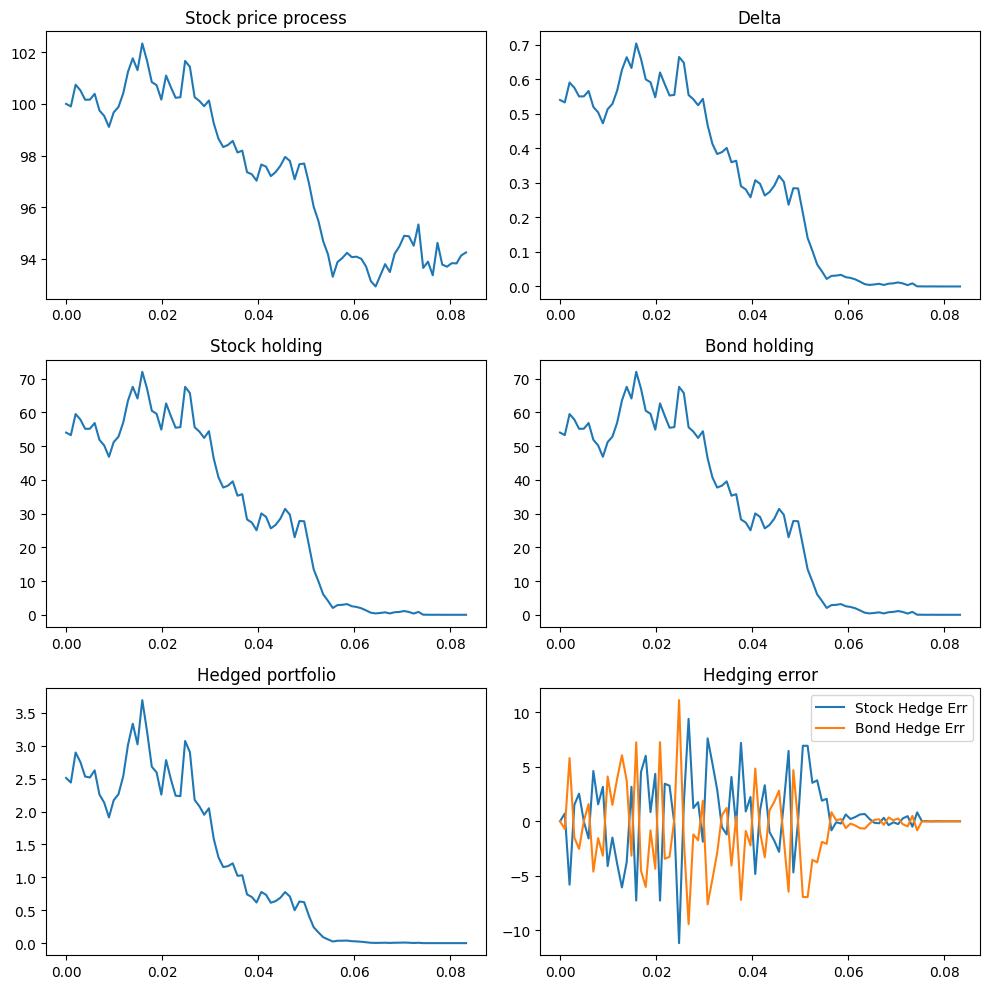

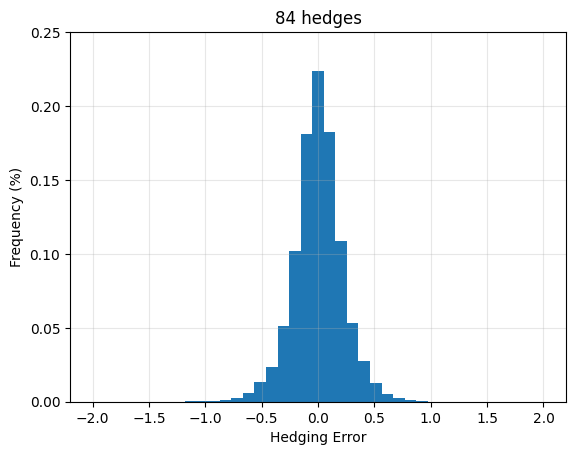

Call option is 2.5120670860398846
Mean is 0.0017534046611610609
Standard Deviation is 0.2183105080191108
Standard Deviation of Hedging Error as a % of option premium 0.08690472847334008


In [68]:
## Plots Result
delta, stock_holdings, bond_holdings, hedged_portfolios, stockhedge_errors, bondhedge_errors = compute_errors(T, blackscholespath, dt_84, K, r, sigma, maturity)

plt_all_info(T, blackscholespath, delta, stock_holdings, bond_holdings, hedged_portfolios, stockhedge_errors, bondhedge_errors)


## Histogram Results
stock_price = S0*np.exp((r-sigma**2/2)*T + sigma*W_T)

iterative_hedging_result = hedging_iteration(steps_84, dt_84)

call_option = BlackScholesVanillaCall(S0, K, r, sigma, maturity)

payoffs = call_option_payoff(stock_price[:,steps_84], K)

hedging_error = iterative_hedging_result + call_option - payoffs

weights=np.ones(len(hedging_error))/len(hedging_error)

mean_of_84_hedge_times = hedging_error.mean()

std_of_84_hedge_times = hedging_error.std()

percent_of_84_hedge_times = std_of_84_hedge_times / call_option

price_check=S0*np.exp(r*T)

print_histogram_summary(hedging_error, weights, 84, call_option, mean_of_84_hedge_times, std_of_84_hedge_times, percent_of_84_hedge_times)

In [69]:
result = pd.DataFrame()
result["Number of Hedges"] = [21 , 84]
result["P&L Mean"] = [mean_of_21_hedge_times, mean_of_84_hedge_times]
result["Standard Deviation of P&L"] = [std_of_21_hedge_times, std_of_84_hedge_times]
result["Standard Deviation of P&L(%) of option premium"] = [percent_of_21_hedge_times*100, percent_of_84_hedge_times*100]
# result = result.set_index("Number of Hedges")

result

,Number of Hedges,P&L Mean,Standard Deviation of P&L,Standard Deviation of P&L(%) of option premium
0,21,-0.003411,0.425582,16.941512
1,84,0.001753,0.218311,8.690473
